## Imports

In [5]:
import numpy as np # library for math
from scipy import signal, ndimage # library for image and signal processing
import matplotlib.pyplot as plt # library for showing images
from skimage import data # sample images
from PIL import Image # library for image functions
import cv2 # computer vision Library
import random as rn
import skimage
import imageio.v3 as iio

# Showing raw image

## Importing github repository for image files

In [6]:
!git clone -l -s https://github.com/Husmarke/SEE120Project
%cd cloned-repo
!ls

fatal: destination path 'SEE120Project' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'cloned-repo'
/content
ef1f08b5923c68ef931b18c78cdf83-710423623.jpg  sample_data  SEE120Project


## opening the image we want to process

(1524, 1524)

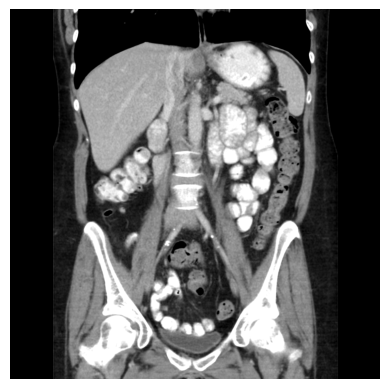

In [15]:
# opening the image
im = iio.imread('/content/ef1f08b5923c68ef931b18c78cdf83-710423623.jpg')
#im = Image.open('/content/SEE120Project/Fig10_38a.tif')
#im = Image.open('/content/SEE120Project/kidney.tif')

# turning the image into a np array
image = np.array(im)

# plotting image
plt.imshow(image, cmap=plt.cm.gray,vmin=0,vmax=255)
plt.axis('off')
np.shape(image)


# Simple extreme value removal and Gaussian filter

The gauss filter is needed in order to remove the gaussian blur and thus making further processing of the image easier. Since the gauss filter isn't very good at removing high and low intensity noise (salt and pepper noise) and tends to just blend the noise into the rest of the image the function clipExtremes removes it beforehand.



---

Gauss filter based on the formula in
https://en.wikipedia.org/wiki/Canny_edge_detector

## clipExtremes() function
Function to remove salt and pepper noise

In [16]:
def clipExtremes(image, lower, upper):
    """
    Clip extreme pixel values of a grayscale image.

    Parameters:
        image (numpy.ndarray): Grayscale image as a 2D numpy array.
        lower (int): Lower value for clipping (0-255).
        upper (int): Upper value for clipping (0-255).

    Returns:
        numpy.ndarray: Processed image with extreme pixel values clipped.
    """
    # check that upper is larger than lower
    assert upper>=lower, "The upper boundry should be larger than the lower"

    # finding image average to replace extreme values
    average = np.average(image)
    # replacing values lower than "lower" and higher than "higher" with image average
    clippedImage = [[image[y][x] if lower<=image[y][x]<=upper else average for x in range(len(image[0]))] for y in range(len(image))]

    # return clipped image
    return clippedImage

### Function for adding noise for testing purposes
Joinked from ppk28:
https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv

In [17]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = rn.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

## testing clipExtremes()

In [18]:
"""
SnPImg = sp_noise(image,0.1)
deNoised = clipExtremes(SnPImg, 10, 245)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 5), sharex=True, sharey=True)
ax[0].imshow(image, cmap=plt.cm.gray,vmin=0,vmax=255)
ax[0].set_title("original")
ax[0].axis('off')
ax[1].imshow(SnPImg, cmap=plt.cm.gray,vmin=0,vmax=255)
ax[1].set_title("Salt & Pepper noise")
ax[1].axis('off')
ax[2].imshow(deNoised, cmap=plt.cm.gray,vmin=0,vmax=255)
ax[2].set_title("Denoised using clipExtremes")
ax[2].axis('off')
"""

'\nSnPImg = sp_noise(image,0.1)\ndeNoised = clipExtremes(SnPImg, 10, 245)\n\n\nfig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 5), sharex=True, sharey=True)\nax[0].imshow(image, cmap=plt.cm.gray,vmin=0,vmax=255)\nax[0].set_title("original")\nax[0].axis(\'off\')\nax[1].imshow(SnPImg, cmap=plt.cm.gray,vmin=0,vmax=255)\nax[1].set_title("Salt & Pepper noise")\nax[1].axis(\'off\')\nax[2].imshow(deNoised, cmap=plt.cm.gray,vmin=0,vmax=255)\nax[2].set_title("Denoised using clipExtremes")\nax[2].axis(\'off\')\n'

## myGauss() function
function to remove gaussian noise

In [19]:
def myGauss(k, sigma, image):
  """
  Convelutes a gauss matrix with an image in order to remove gaussian noise

  Parameters:
      k (int): The size of the gaussian using the formula mSize=2k+1
      sigma (int): The scope  of the filter, higher sigma => less focused and more like a median filter
      image (numpy.ndarray): Grayscale image as a 2D numpy array

  Returns:
      numpy.ndarray: Blurred image
  """
  # finding N (matrix size)
  N =2*k+1;

  # creating empty matrix size NxN
  f = np.zeros([N,N]);

  # calculating the values in the matrix
  for i in range(1,N+1):
    for j in range(1,N+1):
      f[i-1,j-1] = (1/(2*np.pi*sigma**2))*np.exp(-(((i-(k+1))**2+(j-(k+1))**2)/(2*sigma**2)));

  # normalizing the matrix so that the sum(gaussian)=1
  gaussian = f/(sum(map(sum, f)));

  # applying the gaussian and converting to int16 (openCV doesn't support int32)
  image = np.uint16(signal.convolve2d(image,gaussian, mode='same', boundary='fill', fillvalue=0))

  # returing the gaussian and the image
  #print(f)

  #print((sum(map(sum, f))))
  return gaussian, image


In [20]:
#test1, test2 = myGauss(2,1,image)

## Testing the clipExtremes and myGauss function

(-0.5, 1523.5, 1523.5, -0.5)

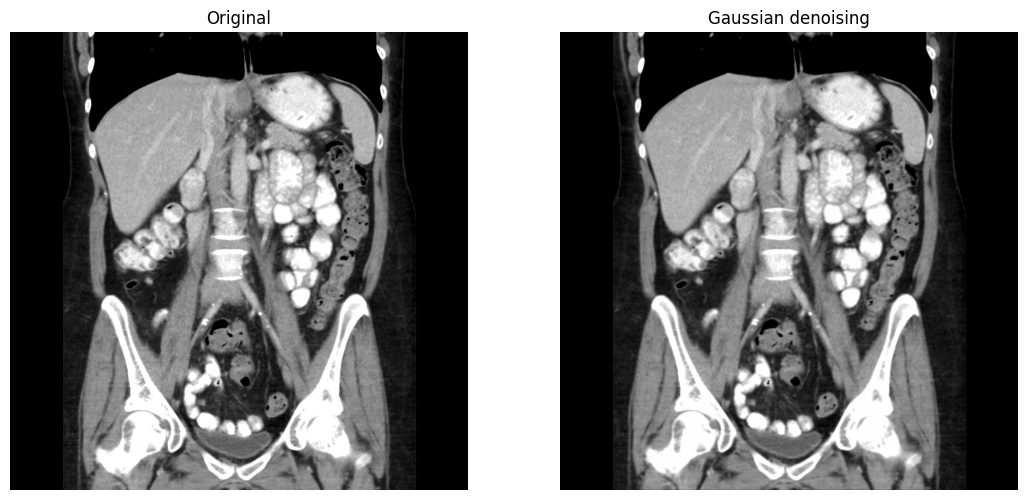

In [21]:
# clipping extreme values of image
clippedImage = clipExtremes(image, 10, 245)

# filtering image using myGauss
filtImage = myGauss(3,1,image)[1]
test = myGauss(9,3,image)[1]

# setting up subplot structure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 7), sharex=True, sharey=True)

# plotting images
ax[0].imshow(image,cmap=plt.cm.gray,vmin=0,vmax=255)
ax[0].set_title('Original')
ax[0].axis('off')

#ax[1].imshow(clippedImage,cmap=plt.cm.gray,vmin=0,vmax=255)
#ax[1].set_title('S&P denoising')
#ax[1].axis('off')

ax[1].imshow(filtImage,cmap=plt.cm.gray,vmin=0,vmax=255)
ax[1].set_title('Gaussian denoising')
ax[1].axis('off')


# Global Tresholding

## Manual global threshing

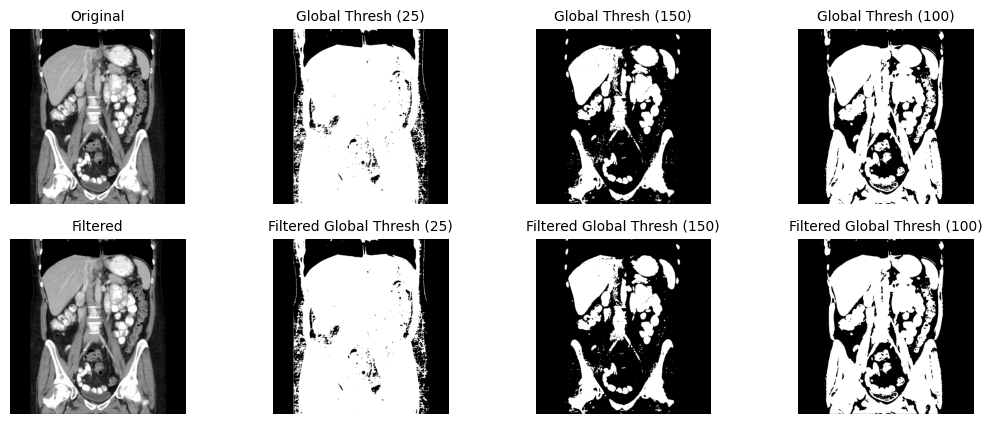

In [22]:
# manual threshing thresholds
t1 = 25
t2 = 150
t3 = 100

# unfiltered threshing
ret,gThresh1 = cv2.threshold(image,t1,255,cv2.THRESH_BINARY)
ret,gThresh2 = cv2.threshold(image,t2,255,cv2.THRESH_BINARY)
ret,gThresh3 = cv2.threshold(image,t3,255,cv2.THRESH_BINARY)

# filtered threshing
ret,gThreshFilt1 = cv2.threshold(filtImage,t1,255,cv2.THRESH_BINARY)
ret,gThreshFilt2 = cv2.threshold(filtImage,t2,255,cv2.THRESH_BINARY)
ret,gThreshFilt3 = cv2.threshold(filtImage,t3,255,cv2.THRESH_BINARY)

#creating figure structure
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(13, 5), sharex=True, sharey=True)

# fontsize of titles
fSize = 10

# putting all titles and images in matrix
titles = [['Original',f'Global Thresh ({t1})',f'Global Thresh ({t2})',f'Global Thresh ({t3})'],
          ['Filtered',f'Filtered Global Thresh ({t1})',f'Filtered Global Thresh ({t2})',f'Filtered Global Thresh ({t3})']]
images = [[image,gThresh1,gThresh2,gThresh3],
          [filtImage,gThreshFilt1,gThreshFilt2,gThreshFilt3]]
# plotting images with for-loop
for i in range(len(titles)):
  for j in range(len(titles[0])):
    ax[i][j].imshow(images[i][j], cmap=plt.cm.gray,vmin=0,vmax=255)
    ax[i][j].set_title(titles[i][j],fontsize=fSize)
    ax[i][j].axis('off')



## Global thresholding with otsu's method using OpenCV

---

Otsu's method
https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html

Optimal threshold from Otsu's:  91.0


(-0.5, 1523.5, 1523.5, -0.5)

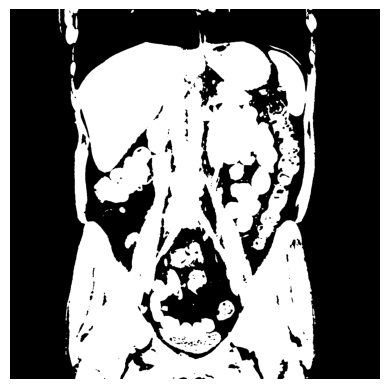

In [23]:
# finding optimal threshold and resulting image with cv2
otsuThreshold, imageResult = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)

# printing optimal threshold value
print("Optimal threshold from Otsu's: ", otsuThreshold)

# showing image
plt.imshow(imageResult,cmap=plt.cm.gray)
plt.axis('off')

## Global threshing with our otsus

In [24]:
def myOtsu(img):
  # finding amount of pixels with grayscale value n from 0-255 (which is a total of 256 different values)
  # f is the histogram and ends are the x coordinates for the bins
  f, ends = np.histogram(image,bins=256)

  # finding the center coordinates of the bins
  binMids = (ends[:-1]+ends[1:])/2.

  # finding pixel value frequency by dividning by total amount of pixels
  h = f/img.size

  # finding p0, p1, mu0 and mu1 using cumelative sums
  p0 = np.cumsum(h)
  p1 = np.cumsum(h[::-1])[::-1]
  mu0 = np.cumsum(h*binMids) /p0
  mu1 = (np.cumsum((h*binMids)[::-1])/p1[::-1])[::-1]

  # finding the inter-class variance sigma^2
  s2 = p0[:-1] * p1[1:] * (mu0[:-1] - mu1[1:]) ** 2

  # finding the index of the values with the maximal inter-class variance
  index_of_max_val = np.argmax(s2)

  # using the binMids to find the actual grayscale threshold
  threshold = binMids[:-1][index_of_max_val]

  # using the optimal threshold value from otsu's to preform global threshing
  thresh = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)[1]

  return threshold, thresh

(-0.5, 1523.5, 1523.5, -0.5)

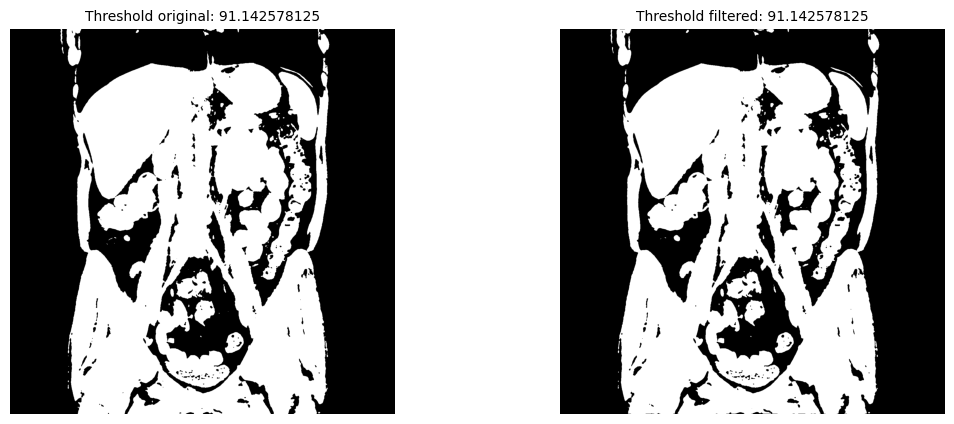

In [25]:
threshold1, threshedImg1 = myOtsu(image)
threshold2, threshedImg2 = myOtsu(filtImage)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].imshow(threshedImg1, cmap=plt.cm.gray)
ax[0].set_title(f"Threshold original: {threshold1}",fontsize=fSize)
ax[0].axis('off')

ax[1].imshow(threshedImg2, cmap=plt.cm.gray)
ax[1].set_title(f"Threshold filtered: {threshold2}",fontsize=fSize)
ax[1].axis('off')

# Function for finding gradients



---


Based on:
https://en.wikipedia.org/wiki/Image_gradient \
and
https://en.wikipedia.org/wiki/Sobel_operator

## myGrad() function

In [26]:
def myGrad(image):
  """
  Takes an image and returns the x and y gradients and the gradient magnetude.

  Parameters:
      image (numpy.ndarray): Grayscale image as a 2D numpy array

  Returns:
      yGrad (numpy.ndarray): Gradient approximation in the y direction
      xGrad (numpy.ndarray): Gradient approximation in the x direction
      mGrad (numpy.ndarray): Magnetude of the y and x gradients
  """

  # sorbel operator matrixes
  ky = [[1,2,1],[0,0,0],[-1,-2,-1]]
  kx = [[1,0,-1],[2,0,-2],[1,0,-1]]

  # convolving image with sorbel operator to approximate gradients
  # if you don't convert to int32 information is lost
  yGrad = ndimage.convolve(np.int32(image),ky)
  xGrad = ndimage.convolve(np.int32(image),kx)

  # calculating gradient magnitude
  mGrad = np.hypot(xGrad, yGrad)

  # normalizing
  mGrad = 255*((mGrad - np.min(mGrad)) / (np.max(mGrad) - np.min(mGrad)))
  return yGrad, xGrad, mGrad


## Testing myGrad() on filtered and unfiltered image

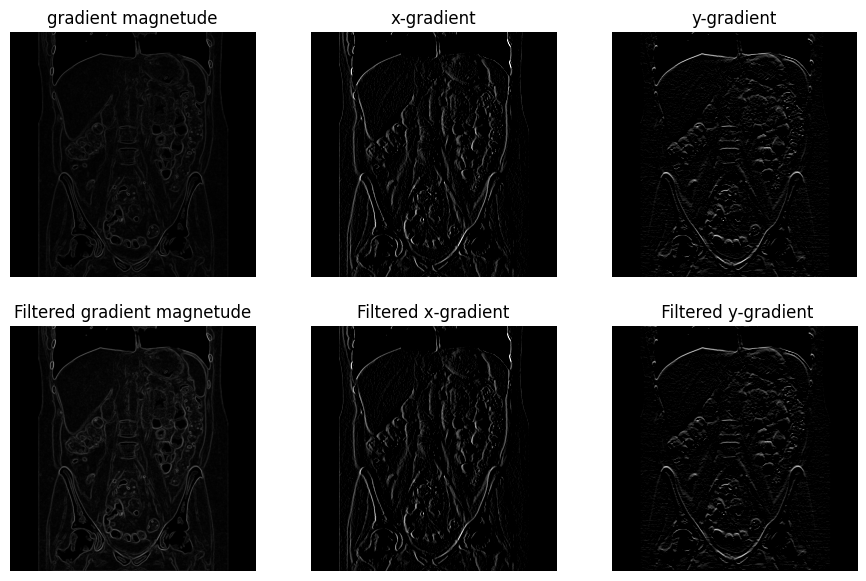

In [27]:
# finding gradients and magentude using myGrad function
yGrad, xGrad, mGrad = myGrad(image)
yGradF, xGradF, mGradF = myGrad(filtImage)

# setting up windows for subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(11, 7), sharex=True, sharey=True)

# putting all titles and images in matrix
titles = [['gradient magnetude','x-gradient','y-gradient'],
          ['Filtered gradient magnetude','Filtered x-gradient',' Filtered y-gradient']]
images = [[mGrad,xGrad,yGrad],[mGradF,xGradF,yGradF]]

#plotting all images
for y in range(len(titles)):
    for x in range(len(titles[0])):
      ax[y][x].imshow(images[y][x],cmap=plt.cm.gray,vmin=0,vmax=255)
      ax[y][x].set_title(titles[y][x])
      ax[y][x].axis('off')


# Improved Otsu's with wighted gradients

You gon need this shit:
https://link.springer.com/chapter/10.1007/978-3-319-23989-7_31#Sec3

## myImprovedOtsu() function

In [28]:
def myImprovedOtsu(image):
  # finding amount of pixels with grayscale value n from 0-255 (which is a total of 256 different values)
  # f is the histogram and ends are the x coordinates for the bins
  f, fEnds = np.histogram(image,bins=257)

  # finding the center coordinates of the bins
  fBinMids = (fEnds[:-1]+fEnds[1:])/2

  # finding pixel value frequency by dividning by total amount of pixels
  h = f/image.size

  # finding p0, p1, mu0 and mu1 using cumelative sums
  p0 = np.cumsum(h)
  p1 = np.cumsum(h[::-1])[::-1]
  mu0 = np.cumsum(h*fBinMids) /p0
  mu1 = (np.cumsum((h*fBinMids)[::-1])/p1[::-1])[::-1]

  # finding the inter-class variance sigma^2
  s2 = p0[:-1] * p1[1:] * (mu0[:-1] - mu1[1:]) ** 2

  # estimating gradient of image
  G = myGrad(image)[2]

  # making two empty lists
  t = np.zeros(256)
  amount = np.zeros(256)

  # looping over every pixel in image
  for y in range(len(image)):
    for x in range(len(image[0])):
      # the gradient of the pixel is added to a list  t(i) where i is a colour value (0-255)
      t[image[y][x]] += G[y][x]
      # the amount of pixels in a colour value is then also added to a list
      amount[image[y][x]] += 1

  # normalizing t
  for i in range(len(t)):
    # divison by zero is not good so we run a check beforehand
    if amount[i]==0:
      t[i]=0
    else:
      # the sum of gradients are divided by the amout of pixels for every colour value
      t[i] = t[i]/amount[i]

  # the final histogram is obtained by multiplying the variance with the weight
  n = s2*t

  # finding the index of the values with the maximal inter-class variance
  index_of_max_val = np.argmax(n)

  # using the fBinMids to find the actual grayscale threshold
  threshold = fBinMids[:-1][index_of_max_val]

  # using the optimal threshold value from otsu's to preform global threshing
  thresh = cv2.threshold(image,threshold,255,cv2.THRESH_BINARY)[1]

  test = [s2, t, n]

  return threshold, thresh, test

## Using the "improved" method on an image

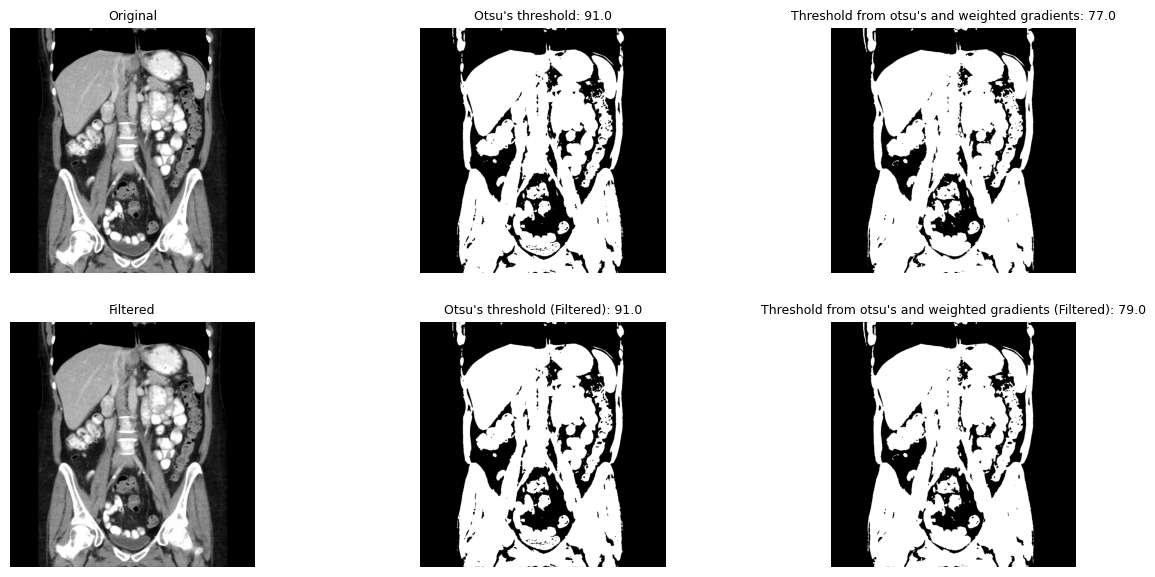

In [29]:



threshold1, threshImg1 = myOtsu(image)
threshold2, threshImg2, test = myImprovedOtsu(image)

thresholdFilt1, threshImgFilt1 = myOtsu(filtImage)
thresholdFilt2, threshImgFilt2, testFilt = myImprovedOtsu(filtImage)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

images = [[image,threshImg1,threshImg2],
          [filtImage,threshImgFilt1,threshImgFilt2]]
titles = [["Original",f"Otsu's threshold: {round(threshold1,0)}",f"Threshold from otsu's and weighted gradients: {round(threshold2,0)}"],
          ["Filtered",f"Otsu's threshold (Filtered): {round(thresholdFilt1,0)}",f"Threshold from otsu's and weighted gradients (Filtered): {round(thresholdFilt2,0)}"]]

for i in range(len(titles)):
  for j in range(len(titles[0])):
    ax[i][j].imshow(images[i][j], cmap=plt.cm.gray,vmin=0,vmax=255)
    ax[i][j].set_title(titles[i][j],fontsize=9)
    ax[i][j].axis('off')



## Showing the histogram and thresholds

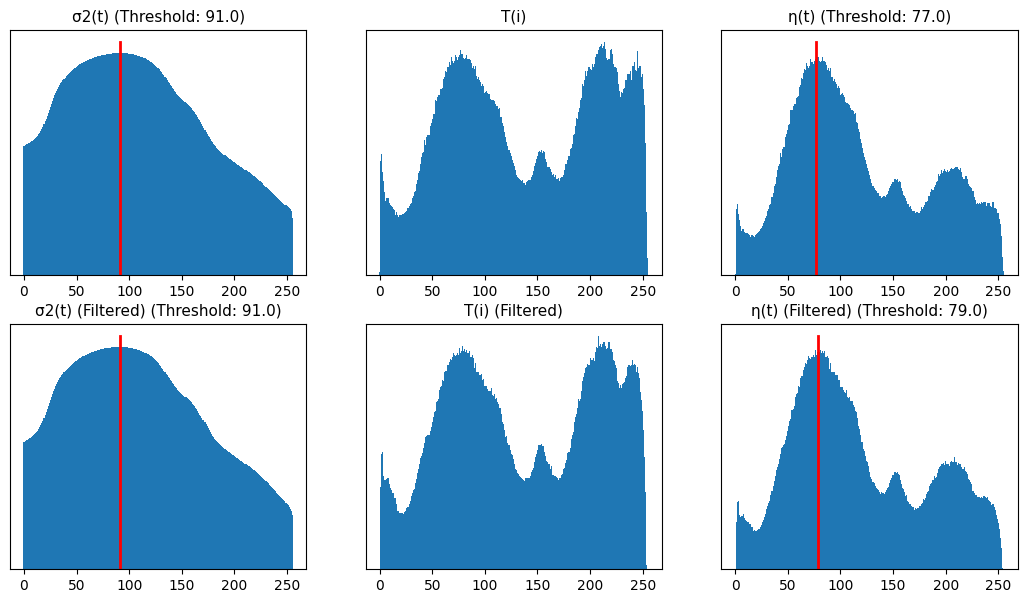

In [31]:

#testing purpouses
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(13, 7))

bars = [test, testFilt]
titles = [[f"σ2(t) (Threshold: {round(threshold1,0)})","T(i)",f"η(t) (Threshold: {round(threshold2,0)})"],
          [f"σ2(t) (Filtered) (Threshold: {round(thresholdFilt1,0)})","T(i) (Filtered)",f"η(t) (Filtered) (Threshold: {round(thresholdFilt2,0)})"]]
for i in range(len(titles)):
  for j in range(len(titles[0])):
    ax[i][j].bar(np.linspace(0,255,256), bars[i][j],width = 1)
    ax[i][j].set_title(titles[i][j],fontsize=11)
    ax[i][j].get_yaxis().set_visible(False)

ax[0][0].plot([threshold1,threshold1], [0,np.max(test[0])*1.05], color='r', linestyle='-', linewidth=2)
ax[1][0].plot([thresholdFilt1,thresholdFilt1], [0,np.max(testFilt[0])*1.05], color='r', linestyle='-', linewidth=2)
ax[0][2].plot([threshold2,threshold2], [0,np.max(test[2])*1.05], color='r', linestyle='-', linewidth=2)
ax[1][2].plot([thresholdFilt2,thresholdFilt2], [0,np.max(testFilt[2])*1.05], color='r', linestyle='-', linewidth=2)



# Experimental Stuff with gradient ascent

In [32]:
def myImprovedOtsuGradAscent(image):
  # finding amount of pixels with grayscale value n from 0-255 (which is a total of 256 different values)
  # f is the histogram and ends are the x coordinates for the bins
  f, fEnds = np.histogram(image,bins=257)

  # finding the center coordinates of the bins
  fBinMids = (fEnds[:-1]+fEnds[1:])/2

  # finding pixel value frequency by dividning by total amount of pixels
  h = f/image.size

  # finding p0, p1, mu0 and mu1 using cumelative sums
  p0 = np.cumsum(h)
  p1 = np.cumsum(h[::-1])[::-1]
  mu0 = np.cumsum(h*fBinMids) /p0
  mu1 = (np.cumsum((h*fBinMids)[::-1])/p1[::-1])[::-1]

  # finding the inter-class variance sigma^2
  s2 = p0[:-1] * p1[1:] * (mu0[:-1] - mu1[1:]) ** 2

  # estimating gradient of image
  G = myGrad(image)[2]

  # making two empty lists
  t = np.zeros(256)
  amount = np.zeros(256)

  # looping over every pixel in image
  for y in range(len(image)):
    for x in range(len(image[0])):
      # the gradient of the pixel is added to a list  t(i) where i is a colour value (0-255)
      t[image[y][x]] += G[y][x]
      # the amount of pixels in a colour value is then also added to a list
      amount[image[y][x]] += 1

  # normalizing t
  for i in range(len(t)):
    # divison by zero is not good so we run a check beforehand
    if amount[i]==0:
      t[i]=0
    else:
      # the sum of gradients are divided by the amout of pixels for every colour value
      t[i] = t[i]/amount[i]

  # the final histogram is obtained by multiplying the variance with the weight
  n = s2*t

  # smoothing out the histogram n to find local minima better
  ntest = np.convolve(n, [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],mode='same')

  # finding the index of the values with "gradient decent"
  testPoints = 10
  maxReqDepth = 30
  localMin = []
  for i in range(testPoints):
    test = int((256/testPoints)*i)
    #print(test)
    reqdepth = 0
    while True:
      if reqdepth > maxReqDepth:
          localMin.append(test)
          break
      try:
        if ntest[test+1]+ntest[test+2]+ntest[test+3] < ntest[test-1]+ntest[test-2]+ntest[test-3]:
            test -=2
        elif ntest[test+1]+ntest[test+2]+ntest[test+3] > ntest[test-1]+ntest[test-2]+ntest[test-3]:
            test += 2
      except: pass
      reqdepth += 1

  # remove unnecessary duplicates and extremes
  localMin.sort()

  for i in range(len(localMin)-1,-1,-1 ):
    if ntest[localMin[i]]<20:
      localMin.pop(i)
  i = 0
  while i < (len(localMin)-1):
    if localMin[i]+5 > localMin[i+1]:
      del localMin[i+1]
    else:
      i+=1
  #print(localMin)

  # using the fBinMids to find the actual grayscale threshold
  thresholds = []
  for i in range(len(localMin)):
    thresholds.append(fBinMids[:-1][localMin[i]])

  # using the optimal threshold value from otsu's to preform global threshing
  threshes = []
  for i in range(len(localMin)):
    threshes.append(cv2.threshold(image,thresholds[i],255,cv2.THRESH_BINARY)[1])

  test = [n, ntest, localMin]


  return thresholds, threshes, test

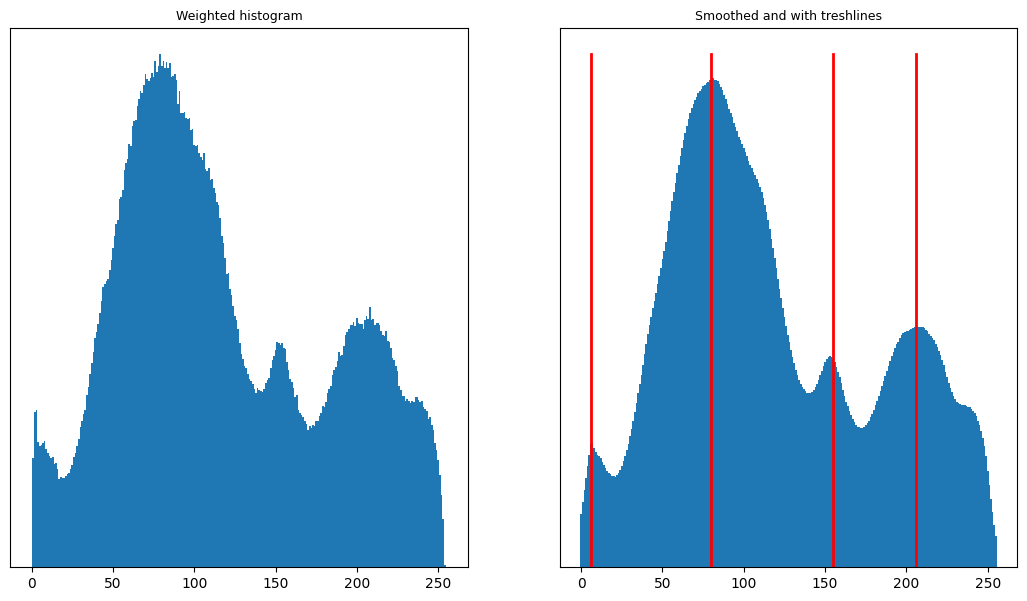

In [36]:
thresholds,threshes,test = myImprovedOtsuGradAscent(filtImage)
[one, two, lines] = test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))
ax[0].bar(np.linspace(0,255,256), one,width = 1)
ax[0].set_title("Weighted histogram",fontsize=9)
ax[0].get_yaxis().set_visible(False)
ax[1].bar(np.linspace(0,255,256), two,width = 1)
ax[1].set_title("Smoothed and with treshlines",fontsize=9)
ax[1].get_yaxis().set_visible(False)


for i in range(len(lines)):
  ax[1].plot([lines[i],lines[i]], [0,np.max(two)*1.05], color='r', linestyle='-', linewidth=2)



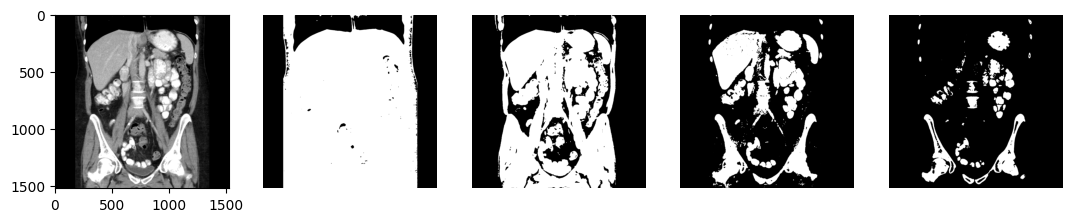

In [34]:

fig, ax = plt.subplots(nrows=1, ncols=len(lines)+1, figsize=(13, 7))
#print(threshes)
for i in range(1,len(lines)+1):
  thresh = cv2.threshold(image,t1,255,cv2.THRESH_BINARY)[1]
  ax[i].imshow(threshes[i-1], cmap=plt.cm.gray,vmin=0,vmax=255)
  #ax[i].set_title(titles[i],fontsize=9)
  ax[i].axis('off')

ax[0].imshow(image, cmap=plt.cm.gray,vmin=0,vmax=255)


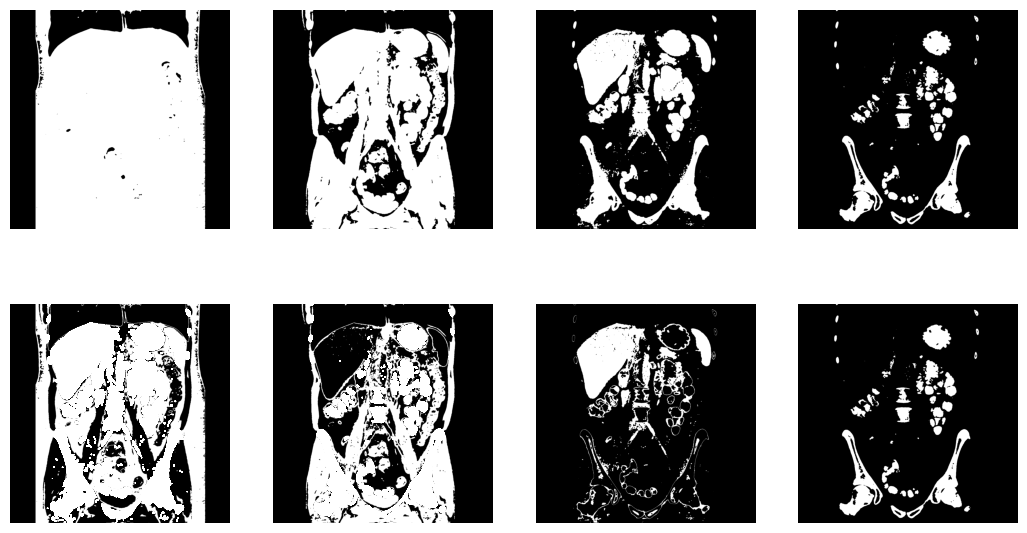

In [35]:
#removing the plots from eachother isolates different parts of the picture
newTresh = threshes.copy()
for i in range(0,len(lines)-1):
  for j in range(i+1,len(lines)):
      #print(i,j)
      newTresh[i] = newTresh[i]-newTresh[j]


fig, ax = plt.subplots(nrows=2, ncols=len(lines), figsize=(13, 7))
for i in range(0,len(lines)):
  ax[0][i].imshow(threshes[i], cmap=plt.cm.gray,vmin=0,vmax=255)
  ax[0][i].axis('off')
  ax[1][i].imshow(newTresh[i], cmap=plt.cm.gray,vmin=0,vmax=255)
  ax[1][i].axis('off')

